Branch "reference_wind"

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation, WindStress
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
nx = 100
ny = 100

dx = 100.0
dy = 100.0

dt = 0.0
g = 9.81
f = 0.0
r = 0.0

ghosts = [2,2,2,2] # north, east, south, west

dataShape = (ny + ghosts[0] + ghosts[2], nx + ghosts[1] + ghosts[3])

eta0 = np.zeros(dataShape, dtype=np.float32)
hu0 = -1*np.ones(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)
Hi = 10 * np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')

boundary_conditions = Common.BoundaryConditions(2,2,2,2)

T = 600

In [5]:
wind_t = np.array([0])
wind_u = [np.array([[10]])]
wind_v = [np.array([[ 0]])]

rho_a = 1.225 # Density of air
rho_w = 1025 # Density of water

wind_stress_u = []
wind_stress_v = []
for t in range(len(wind_t)):
    # Technically requires compatible shape between wind_u[t] and wind_v[t]
    wind_speed = np.sqrt(np.power(wind_u[t], 2) + np.power(wind_v[t], 2))
    C_drag = np.where(wind_speed < 11, 0.0012, 0.00049 + 0.000065*wind_speed)

    wind_stress = C_drag * wind_speed * rho_a / rho_w
    wind_stress_u.append( wind_stress*wind_u[t] )
    wind_stress_v.append( wind_stress*wind_v[t] )

wind_forcing = WindStress.WindStress(t=wind_t, X=np.float32(wind_stress_u), Y=np.float32(wind_stress_v))

In [6]:
sim = CDKLM16.CDKLM16(gpu_ctx, \
                        eta0, hu0, hv0, Hi, \
                        nx, ny, \
                        dx, dy, dt, \
                        g, f, r, \
                        boundary_conditions=boundary_conditions,
                        wind_stress=wind_forcing)

In [7]:
observation_args = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                'nx': sim.nx, 'ny': sim.ny,
                'domain_size_x': sim.nx*sim.dx,
                'domain_size_y': sim.ny*sim.dy,
                'land_mask': sim.getLandMask()
               }

forecast = Observation.Observation(**observation_args)

In [8]:
wind = WindStress.WindStress(t=wind_t, X=np.float32(wind_v), Y=np.float32(wind_u))

In [9]:
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, 1, 
                                                 wind = wind, wind_drift_factor=0.02,
                                                 boundaryConditions = sim.boundary_conditions,
                                                 domain_size_x = forecast.domain_size_x,
                                                 domain_size_y = forecast.domain_size_y,
                                                 gpu_stream = sim.gpu_stream)

In [10]:
drifters.setDrifterPositions([[int(0.5*ny*dy),int(0.5*ny*dy)]])
sim.attachDrifters(drifters)

In [11]:
for min in range(T):
    sim.step(10)
    forecast.add_observation_from_sim(sim)

In [12]:
pos = []
for i in range(len(forecast.obs_df["drifter_positions"])):
    pos.append([forecast.obs_df["drifter_positions"].iloc[i][0][0].item(),forecast.obs_df["drifter_positions"].iloc[i][0][1].item()])
pos = np.array(pos)

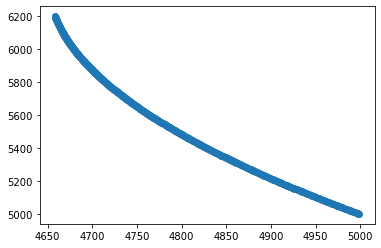

In [13]:
plt.scatter(pos[:,0],pos[:,1])

In [14]:
pos[-1,0],pos[-1,1]

(4658.2216796875, 6200.29296875)